### Import modules

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


### Import Dataset

In [2]:
 pd.set_option('display.max_columns', None)
workers_df = pd.read_csv("../data/raw/factory_workers.csv", sep=',', encoding="mac_roman")

In [3]:
workers_df.head()

,sub_ID,sub_fname,sub_lname,sub_age,sub_sex,sub_shift,sub_team,sub_role,sub_coll_IDs,sub_colls_same_sex_prtn,sub_health_h,sub_commitment_h,sub_perceptiveness_h,sub_dexterity_h,sub_sociality_h,sub_goodness_h,sub_strength_h,sub_openmindedness_h,sub_workstyle_h,sup_ID,sup_fname,sup_lname,sup_age,sup_sub_age_diff,sup_sex,sup_role,sup_commitment_h,sup_perceptiveness_h,sup_goodness_h,event_date,event_week_in_series,event_day_in_series,event_weekday_num,event_weekday_name,behav_comptype_h,behav_cause_h,actual_efficacy_h,record_comptype,record_cause,recorded_efficacy,recorded_note_from_sup,record_conf_matrix_h
0,98000001,Rebecca,Bauer,40,F,Shift 1,Team 1,Team Leader,"[98000002, 98000003, 98000004, 98000005, 98000...",0.714285714,0.895,1.000,0.659,0.592,0.799,0.501,0.484,0.676,Group A,98000216,Susan,Dahl,24,-16,F,Shift Manager,0.842,0.948,0.971,1/1/2021,1,1,4,Friday,Presence,None,None,Presence,None,None,None,None
1,98000001,Rebecca,Bauer,40,F,Shift 1,Team 1,Team Leader,"[98000002, 98000003, 98000004, 98000005, 98000...",0.714285714,0.895,1.000,0.659,0.592,0.799,0.501,0.484,0.676,Group A,98000216,Susan,Dahl,24,-16,F,Shift Manager,0.842,0.948,0.971,1/1/2021,1,1,4,Friday,Efficacy,None,1.489,Efficacy,None,1.2,None,None
2,98000002,Joan,Winter,61,F,Shift 1,Team 2,Team Leader,"[98000001, 98000003, 98000004, 98000005, 98000...",0.714285714,0.752,0.563,0.449,0.766,0.872,0.655,0.786,0.908,Group C,98000216,Susan,Dahl,24,-37,F,Shift Manager,0.842,0.948,0.971,1/1/2021,1,1,4,Friday,Presence,None,None,Presence,None,None,None,None
3,98000002,Joan,Winter,61,F,Shift 1,Team 2,Team Leader,"[98000001, 98000003, 98000004, 98000005, 98000...",0.714285714,0.752,0.563,0.449,0.766,0.872,0.655,0.786,0.908,Group C,98000216,Susan,Dahl,24,-37,F,Shift Manager,0.842,0.948,0.971,1/1/2021,1,1,4,Friday,Efficacy,None,1.023,Efficacy,None,0.8,None,None
4,98000003,Elizabeth,Martinez,20,F,Shift 1,Team 3,Team Leader,"[98000001, 98000002, 98000004, 98000005, 98000...",0.714285714,0.573,0.907,0.735,0.878,0.985,0.840,0.900,0.777,Group C,98000216,Susan,Dahl,24,4,F,Shift Manager,0.842,0.948,0.971,1/1/2021,1,1,4,Friday,Presence,None,None,Presence,None,None,None,None


### Drop Unnecessary Columns

In [4]:
# drop unnecessary columns
unnecessary_cols = ['sub_fname', 'sub_lname','sub_coll_IDs', 'sub_colls_same_sex_prtn','sup_fname', 'sup_lname','event_week_in_series',
 'event_day_in_series','event_weekday_num', 'event_weekday_name', 'recorded_note_from_sup', 'record_conf_matrix_h', 
                   'behav_cause_h', 'record_cause']

workers_df.drop(columns=unnecessary_cols, inplace=True)

In [5]:
# drop all rows with production director as sub_role
workers_df = workers_df[workers_df['sub_role'] != 'Production Director']

In [6]:
# check df
workers_df.head()

,sub_ID,sub_age,sub_sex,sub_shift,sub_team,sub_role,sub_health_h,sub_commitment_h,sub_perceptiveness_h,sub_dexterity_h,sub_sociality_h,sub_goodness_h,sub_strength_h,sub_openmindedness_h,sub_workstyle_h,sup_ID,sup_age,sup_sub_age_diff,sup_sex,sup_role,sup_commitment_h,sup_perceptiveness_h,sup_goodness_h,event_date,behav_comptype_h,actual_efficacy_h,record_comptype,recorded_efficacy
0,98000001,40,F,Shift 1,Team 1,Team Leader,0.895,1.000,0.659,0.592,0.799,0.501,0.484,0.676,Group A,98000216,24,-16,F,Shift Manager,0.842,0.948,0.971,1/1/2021,Presence,None,Presence,None
1,98000001,40,F,Shift 1,Team 1,Team Leader,0.895,1.000,0.659,0.592,0.799,0.501,0.484,0.676,Group A,98000216,24,-16,F,Shift Manager,0.842,0.948,0.971,1/1/2021,Efficacy,1.489,Efficacy,1.2
2,98000002,61,F,Shift 1,Team 2,Team Leader,0.752,0.563,0.449,0.766,0.872,0.655,0.786,0.908,Group C,98000216,24,-37,F,Shift Manager,0.842,0.948,0.971,1/1/2021,Presence,None,Presence,None
3,98000002,61,F,Shift 1,Team 2,Team Leader,0.752,0.563,0.449,0.766,0.872,0.655,0.786,0.908,Group C,98000216,24,-37,F,Shift Manager,0.842,0.948,0.971,1/1/2021,Efficacy,1.023,Efficacy,0.8
4,98000003,20,F,Shift 1,Team 3,Team Leader,0.573,0.907,0.735,0.878,0.985,0.840,0.900,0.777,Group C,98000216,24,4,F,Shift Manager,0.842,0.948,0.971,1/1/2021,Presence,None,Presence,None


### Create target variable column

In [7]:
# create a binary column based on whether a worker resigned or not
workers_df['Resigned'] = [1 if x == 'Resignation' else 0 for x in workers_df['behav_comptype_h']]

### Feature Engineering: Encode Categorical Variables

In [8]:
# Get a list of relevant events
relevant_events = list(workers_df['behav_comptype_h'].unique())
sabotage = relevant_events[-1]
relevant_events = relevant_events[:10]
relevant_events.append(sabotage)
relevant_events

['Presence',
 'Efficacy',
 'Feat',
 'Slip',
 'Sacrifice',
 'Lapse',
 'Idea',
 'Teamwork',
 'Absence',
 'Disruption',
 'Sabotage']

***Count the number of instances each employee had an underrecorded efficacy score***

In [9]:
# Find a count of underrecorded efficacy for each employee
underrecorded_efficacies = workers_df[workers_df['recorded_efficacy'] < workers_df['actual_efficacy_h']]
underrecorded_efficacies

# Group underrecorded efficacies by sub_ID and get count
efficacy = underrecorded_efficacies.groupby('sub_ID')['recorded_efficacy'].count().reset_index()

# Rename col
efficacy.rename(columns={'recorded_efficacy':'Num Underrecorded Efficacy'}, inplace=True)
efficacy.sort_values(by='Num Underrecorded Efficacy', ascending=False).head()

,sub_ID,Num Underrecorded Efficacy
347,98000425,213
447,98000539,213
156,98000195,212
95,98000123,211
495,98000600,211


***Count the number of instances each employee had a mismatched relevant event recorded***

In [10]:
# Filter df based on relevant events
relevant_events_df = workers_df[workers_df['behav_comptype_h'].isin(relevant_events)]

In [11]:
# Find a count of mismatched recorded events for each employee
mismatched_events = relevant_events_df[relevant_events_df['behav_comptype_h'] != relevant_events_df['record_comptype']]

# Group by sub_ID and get a count of each mismatched event
events = mismatched_events.groupby('sub_ID')['behav_comptype_h'].count().reset_index()

# Rename column and sort
events.rename(columns={'behav_comptype_h':'Num Mismatched Events'}, inplace=True)
events.sort_values('Num Mismatched Events', ascending=False).head()

,sub_ID,Num Mismatched Events
415,98000532,15
426,98000547,15
100,98000137,12
264,98000349,12
167,98000219,12


In [12]:
# Merge Mismatched Efficacies and Events 
new_features = efficacy.merge(events, left_on='sub_ID', right_on='sub_ID', how='left')
new_features

,sub_ID,Num Underrecorded Efficacy,Num Mismatched Events
0,98000001,185,7.0
1,98000002,202,4.0
2,98000003,194,6.0
3,98000004,183,5.0
4,98000005,181,5.0
...,...,...,...
680,98000785,9,NaN
681,98000786,5,2.0
682,98000787,7,NaN
683,98000788,1,1.0


In [13]:
# fill missing values for Mismatched events column with 0
new_features.fillna(0, inplace=True)

# Convert data type to int for mismatched events col
new_features['Num Mismatched Events'] = new_features['Num Mismatched Events'].astype('int')
new_features.dtypes

sub_ID                        int64
Num Underrecorded Efficacy    int64
Num Mismatched Events         int64
dtype: object

In [14]:
# Merge new features to original dataframe
merged_df = workers_df.merge(new_features, left_on='sub_ID', right_on='sub_ID')

### Drop duplicate rows and some Categorical Features

In [15]:
# drop features already encoded
features_to_drop = ['behav_comptype_h', 'record_comptype', 'actual_efficacy_h', 'recorded_efficacy']
merged_df.drop(columns=features_to_drop, inplace=True)

In [16]:
# drop duplicate rows based on last event date
df = merged_df.sort_values('event_date').drop_duplicates('sub_ID', keep='last')
df = df.sort_values('sub_ID')

# Convert event_date col to datetime 
df['event_date'] = pd.to_datetime(df['event_date'])

### Create Dummy Variables for Categorical Features

In [17]:
# Features to encode
cat_vars = ['sub_sex', 'sub_shift', 'sub_team', 'sub_role', 'sub_workstyle_h', 'sup_sex', 'sup_role']

In [18]:
# Get dummy variables
df = pd.get_dummies(df, columns=cat_vars, prefix=cat_vars, drop_first=True)

In [19]:
# Inspect encoded features
df.head()

,sub_ID,sub_age,sub_health_h,sub_commitment_h,sub_perceptiveness_h,sub_dexterity_h,sub_sociality_h,sub_goodness_h,sub_strength_h,sub_openmindedness_h,sup_ID,sup_age,sup_sub_age_diff,sup_commitment_h,sup_perceptiveness_h,sup_goodness_h,event_date,Resigned,Num Underrecorded Efficacy,Num Mismatched Events,sub_sex_M,sub_shift_Shift 2,sub_shift_Shift 3,sub_team_Team 10,sub_team_Team 11,sub_team_Team 12,sub_team_Team 13,sub_team_Team 14,sub_team_Team 15,sub_team_Team 16,sub_team_Team 17,sub_team_Team 18,sub_team_Team 19,sub_team_Team 2,sub_team_Team 20,sub_team_Team 21,sub_team_Team 22,sub_team_Team 23,sub_team_Team 24,sub_team_Team 3,sub_team_Team 4,sub_team_Team 5,sub_team_Team 6,sub_team_Team 7,sub_team_Team 8,sub_team_Team 9,sub_team_unassigned,sub_role_Shift Manager,sub_role_Team Leader,sub_workstyle_h_Group B,sub_workstyle_h_Group C,sub_workstyle_h_Group D,sub_workstyle_h_Group E,sup_sex_M,sup_role_Shift Manager,sup_role_Team Leader
377,98000001,40,0.895,1.000,0.659,0.592,0.799,0.501,0.484,0.676,98000216,24,-16,0.842,0.948,0.971,2021-09-09,0,185,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1191,98000002,61,0.752,0.563,0.449,0.766,0.872,0.655,0.786,0.908,98000216,24,-37,0.842,0.948,0.971,2021-09-09,0,202,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
1991,98000003,20,0.573,0.907,0.735,0.878,0.985,0.840,0.900,0.777,98000216,24,4,0.842,0.948,0.971,2021-09-09,0,194,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
2796,98000004,18,0.547,0.819,0.659,0.776,0.556,0.755,0.872,0.382,98000216,24,6,0.842,0.948,0.971,2021-09-09,0,183,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
3592,98000005,59,0.777,0.629,0.678,0.749,0.652,0.686,0.566,0.336,98000216,24,-35,0.842,0.948,0.971,2021-09-09,0,181,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0


In [20]:
# Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 685 entries, 377 to 411132
Data columns (total 56 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   sub_ID                      685 non-null    int64         
 1   sub_age                     685 non-null    int64         
 2   sub_health_h                685 non-null    float64       
 3   sub_commitment_h            685 non-null    float64       
 4   sub_perceptiveness_h        685 non-null    float64       
 5   sub_dexterity_h             685 non-null    float64       
 6   sub_sociality_h             685 non-null    float64       
 7   sub_goodness_h              685 non-null    float64       
 8   sub_strength_h              685 non-null    float64       
 9   sub_openmindedness_h        685 non-null    float64       
 10  sup_ID                      685 non-null    object        
 11  sup_age                     685 non-null    object   

In [21]:
# get features with object types to convert to int
o_types = df.select_dtypes(include=['object'], exclude=['datetime']).columns.to_list()

# convert to num type
df[o_types] = df[o_types].apply(pd.to_numeric, errors='coerce')

### Create train and test splits

In [22]:
# Create target variable and feature matrix
X = df.drop(columns=['sub_ID', 'sup_ID', 'event_date', 'Resigned'])
y = df['Resigned']

In [23]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
# View train set
X_train.head()

,sub_age,sub_health_h,sub_commitment_h,sub_perceptiveness_h,sub_dexterity_h,sub_sociality_h,sub_goodness_h,sub_strength_h,sub_openmindedness_h,sup_age,sup_sub_age_diff,sup_commitment_h,sup_perceptiveness_h,sup_goodness_h,Num Underrecorded Efficacy,Num Mismatched Events,sub_sex_M,sub_shift_Shift 2,sub_shift_Shift 3,sub_team_Team 10,sub_team_Team 11,sub_team_Team 12,sub_team_Team 13,sub_team_Team 14,sub_team_Team 15,sub_team_Team 16,sub_team_Team 17,sub_team_Team 18,sub_team_Team 19,sub_team_Team 2,sub_team_Team 20,sub_team_Team 21,sub_team_Team 22,sub_team_Team 23,sub_team_Team 24,sub_team_Team 3,sub_team_Team 4,sub_team_Team 5,sub_team_Team 6,sub_team_Team 7,sub_team_Team 8,sub_team_Team 9,sub_team_unassigned,sub_role_Shift Manager,sub_role_Team Leader,sub_workstyle_h_Group B,sub_workstyle_h_Group C,sub_workstyle_h_Group D,sub_workstyle_h_Group E,sup_sex_M,sup_role_Shift Manager,sup_role_Team Leader
381403,30,0.689,0.818,0.752,0.664,0.726,0.582,0.939,0.851,31,1,0.762,0.494,0.799,129,2,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
167759,25,0.753,0.631,0.898,0.570,0.869,0.936,0.608,0.915,22,-3,0.661,0.909,0.562,189,8,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
61766,58,0.650,0.892,0.883,0.790,0.850,0.589,0.501,0.546,59,1,0.629,0.678,0.686,184,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
11973,62,0.851,0.581,0.771,0.595,0.894,0.683,0.824,0.483,54,-8,0.966,0.802,0.931,190,8,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
398971,50,0.758,0.589,0.738,0.845,0.728,0.346,0.705,0.827,23,-27,0.864,0.979,0.941,10,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0


### Preprocessing: Standardize Numeric Features

In [25]:
# Get numeric features
num_features = ['sub_age', 'sub_health_h', 'sub_commitment_h',
       'sub_perceptiveness_h', 'sub_dexterity_h', 'sub_sociality_h',
       'sub_goodness_h', 'sub_strength_h', 'sub_openmindedness_h',
       'Num Underrecorded Efficacy', 'Num Mismatched Events', 'sup_age', 'sup_sub_age_diff',
               'sup_commitment_h', 'sup_perceptiveness_h', 'sup_goodness_h']

In [26]:
# instantiate scaler
SS_scaler = StandardScaler()

# fit values to scaler
SS_scaler.fit(X_train[num_features])

# Get standardized values as a new df
X_train[num_features] = SS_scaler.transform(X_train[num_features])


In [27]:
# View train set with updated scaled values
X_train

,sub_age,sub_health_h,sub_commitment_h,sub_perceptiveness_h,sub_dexterity_h,sub_sociality_h,sub_goodness_h,sub_strength_h,sub_openmindedness_h,sup_age,sup_sub_age_diff,sup_commitment_h,sup_perceptiveness_h,sup_goodness_h,Num Underrecorded Efficacy,Num Mismatched Events,sub_sex_M,sub_shift_Shift 2,sub_shift_Shift 3,sub_team_Team 10,sub_team_Team 11,sub_team_Team 12,sub_team_Team 13,sub_team_Team 14,sub_team_Team 15,sub_team_Team 16,sub_team_Team 17,sub_team_Team 18,sub_team_Team 19,sub_team_Team 2,sub_team_Team 20,sub_team_Team 21,sub_team_Team 22,sub_team_Team 23,sub_team_Team 24,sub_team_Team 3,sub_team_Team 4,sub_team_Team 5,sub_team_Team 6,sub_team_Team 7,sub_team_Team 8,sub_team_Team 9,sub_team_unassigned,sub_role_Shift Manager,sub_role_Team Leader,sub_workstyle_h_Group B,sub_workstyle_h_Group C,sub_workstyle_h_Group D,sub_workstyle_h_Group E,sup_sex_M,sup_role_Shift Manager,sup_role_Team Leader
381403,-0.850554,-0.329809,0.472468,0.084639,-0.453258,-0.078134,-1.046891,1.239502,0.640347,-0.631135,0.129004,0.092999,-1.357193,0.600156,-0.074942,-0.848317,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
167759,-1.220008,0.083950,-0.742748,0.988512,-1.062269,0.801082,1.288157,-0.816038,1.055826,-1.261631,-0.077252,-0.625897,1.000952,-0.902009,0.859844,1.114572,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
61766,1.218390,-0.581943,0.953355,0.895648,0.363075,0.684263,-1.000718,-1.480517,-1.339666,1.330407,0.129004,-0.853667,-0.311654,-0.116066,0.781945,-0.194020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
11973,1.513953,0.717519,-1.067672,0.202266,-0.900298,0.954791,-0.380677,0.525342,-1.748653,0.980132,-0.335071,1.545027,0.392948,1.436804,0.875424,1.114572,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
398971,0.627263,0.116275,-1.015684,-0.002034,0.719411,-0.065837,-2.603590,-0.213659,0.484543,-1.191575,-1.314786,0.819013,1.398711,1.500187,-1.928935,-1.502613,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379956,0.036136,0.316690,0.381489,0.499430,-1.010438,1.206874,-0.512600,0.425980,0.101524,1.540572,1.108719,-1.131260,0.069058,-0.236493,-1.072048,-0.194020,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
53522,-1.589462,-0.601338,0.667422,-0.224906,1.114619,0.032537,0.001902,1.003519,0.406641,-1.541851,-0.025688,0.498712,-0.419618,0.321273,0.454770,1.768869,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
396162,-0.259427,-0.737103,-0.248863,-2.806515,0.259413,-0.490074,1.433273,-0.387541,1.042842,0.489746,0.541515,-1.088553,0.438406,-0.369596,-0.511176,-1.175465,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
309636,-0.776663,0.342550,0.238523,1.161857,0.641665,0.210839,-0.862198,-1.468097,-1.170878,-1.541851,-0.592891,0.498712,-0.419618,0.321273,0.049696,-0.521169,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [28]:
# Show new standardized features
scaled_data = pd.DataFrame(X_train[num_features], columns=num_features)

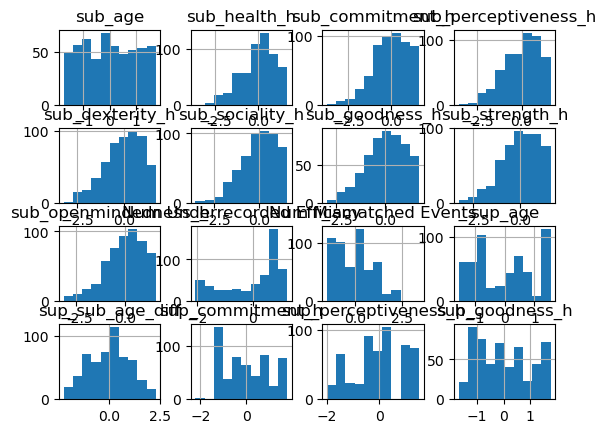

In [29]:
# Visualize shape of features 
scaled_data.hist()
plt.show()

In [30]:
X_train

,sub_age,sub_health_h,sub_commitment_h,sub_perceptiveness_h,sub_dexterity_h,sub_sociality_h,sub_goodness_h,sub_strength_h,sub_openmindedness_h,sup_age,sup_sub_age_diff,sup_commitment_h,sup_perceptiveness_h,sup_goodness_h,Num Underrecorded Efficacy,Num Mismatched Events,sub_sex_M,sub_shift_Shift 2,sub_shift_Shift 3,sub_team_Team 10,sub_team_Team 11,sub_team_Team 12,sub_team_Team 13,sub_team_Team 14,sub_team_Team 15,sub_team_Team 16,sub_team_Team 17,sub_team_Team 18,sub_team_Team 19,sub_team_Team 2,sub_team_Team 20,sub_team_Team 21,sub_team_Team 22,sub_team_Team 23,sub_team_Team 24,sub_team_Team 3,sub_team_Team 4,sub_team_Team 5,sub_team_Team 6,sub_team_Team 7,sub_team_Team 8,sub_team_Team 9,sub_team_unassigned,sub_role_Shift Manager,sub_role_Team Leader,sub_workstyle_h_Group B,sub_workstyle_h_Group C,sub_workstyle_h_Group D,sub_workstyle_h_Group E,sup_sex_M,sup_role_Shift Manager,sup_role_Team Leader
381403,-0.850554,-0.329809,0.472468,0.084639,-0.453258,-0.078134,-1.046891,1.239502,0.640347,-0.631135,0.129004,0.092999,-1.357193,0.600156,-0.074942,-0.848317,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
167759,-1.220008,0.083950,-0.742748,0.988512,-1.062269,0.801082,1.288157,-0.816038,1.055826,-1.261631,-0.077252,-0.625897,1.000952,-0.902009,0.859844,1.114572,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
61766,1.218390,-0.581943,0.953355,0.895648,0.363075,0.684263,-1.000718,-1.480517,-1.339666,1.330407,0.129004,-0.853667,-0.311654,-0.116066,0.781945,-0.194020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
11973,1.513953,0.717519,-1.067672,0.202266,-0.900298,0.954791,-0.380677,0.525342,-1.748653,0.980132,-0.335071,1.545027,0.392948,1.436804,0.875424,1.114572,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
398971,0.627263,0.116275,-1.015684,-0.002034,0.719411,-0.065837,-2.603590,-0.213659,0.484543,-1.191575,-1.314786,0.819013,1.398711,1.500187,-1.928935,-1.502613,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379956,0.036136,0.316690,0.381489,0.499430,-1.010438,1.206874,-0.512600,0.425980,0.101524,1.540572,1.108719,-1.131260,0.069058,-0.236493,-1.072048,-0.194020,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
53522,-1.589462,-0.601338,0.667422,-0.224906,1.114619,0.032537,0.001902,1.003519,0.406641,-1.541851,-0.025688,0.498712,-0.419618,0.321273,0.454770,1.768869,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
396162,-0.259427,-0.737103,-0.248863,-2.806515,0.259413,-0.490074,1.433273,-0.387541,1.042842,0.489746,0.541515,-1.088553,0.438406,-0.369596,-0.511176,-1.175465,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
309636,-0.776663,0.342550,0.238523,1.161857,0.641665,0.210839,-0.862198,-1.468097,-1.170878,-1.541851,-0.592891,0.498712,-0.419618,0.321273,0.049696,-0.521169,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


### Check for Outliers with Boxplots

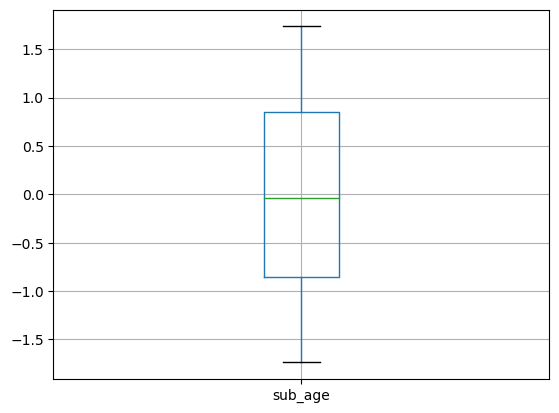

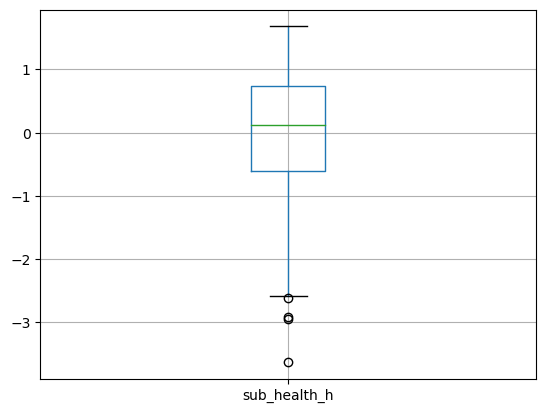

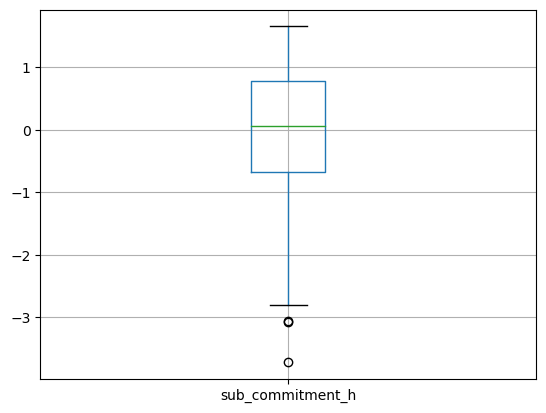

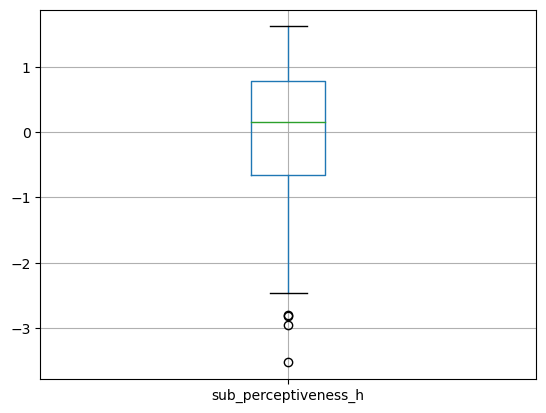

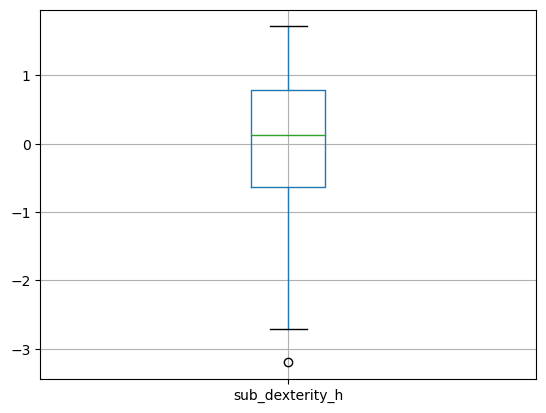

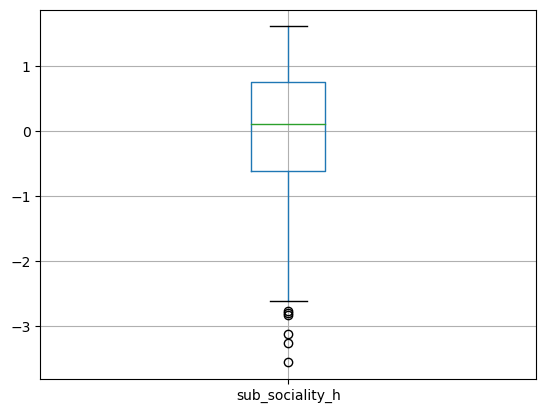

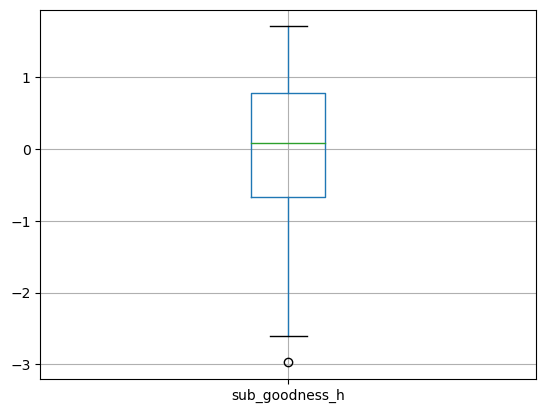

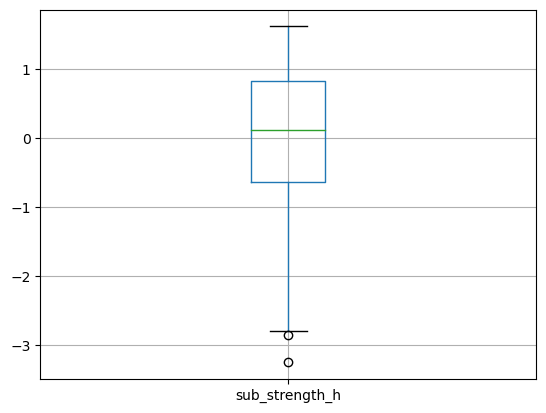

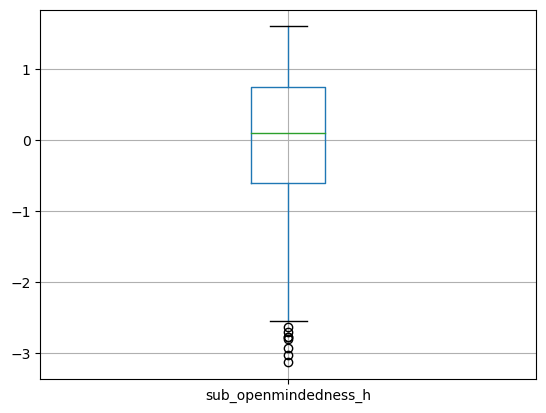

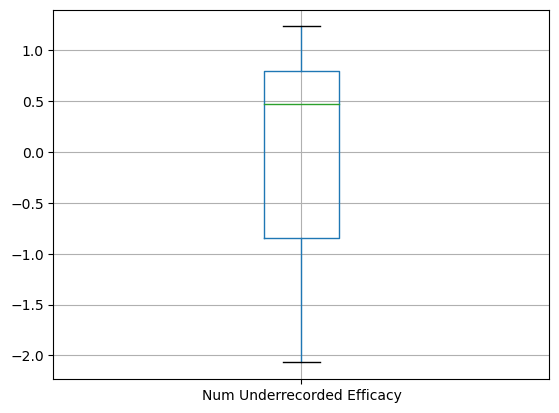

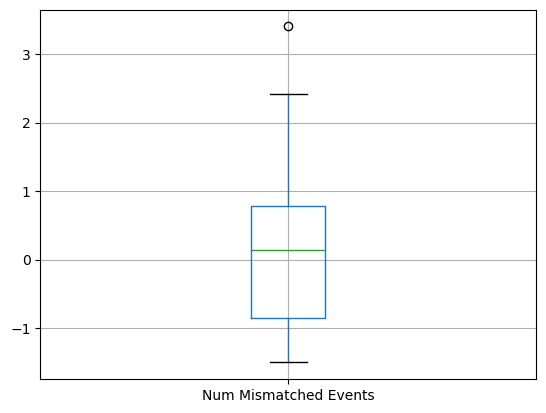

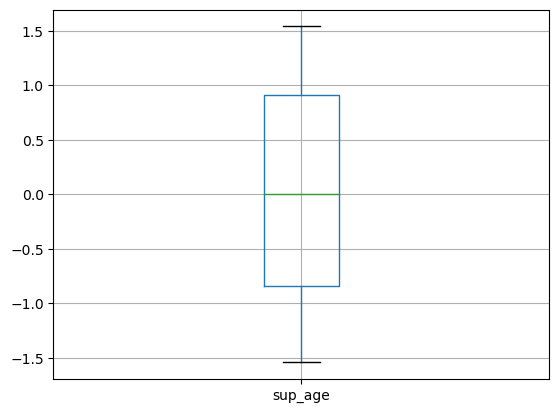

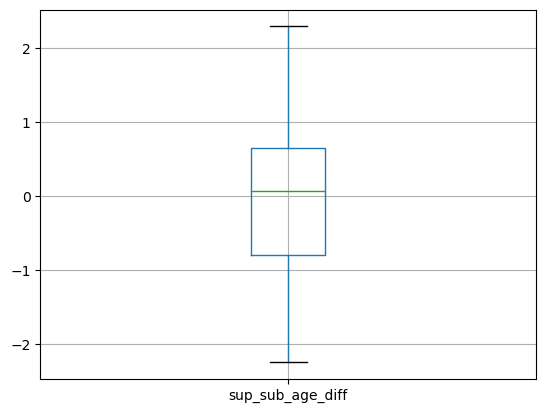

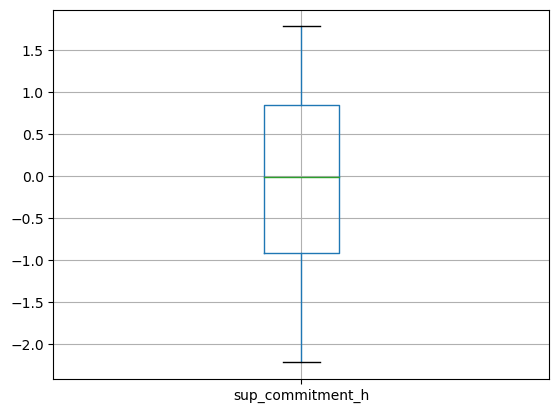

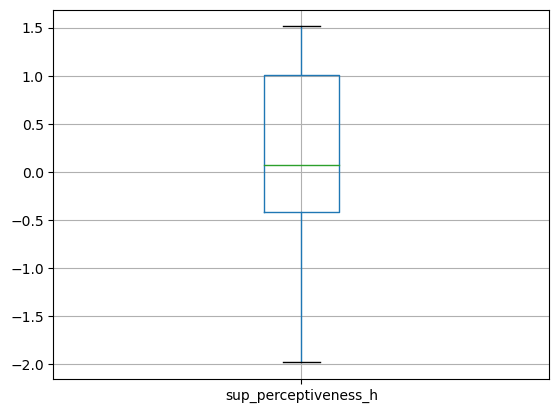

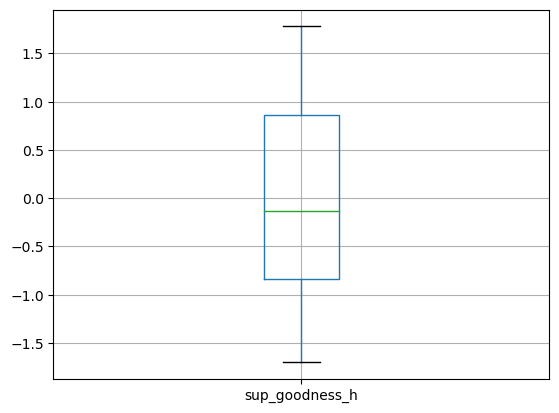

In [31]:
for feature in X_train[num_features].columns:
    X_train[[feature]].boxplot()
    plt.show()

## Export train and test data

In [32]:
try:
    X_train.to_csv('../data/processed/X_train.csv', index=False)
    X_test.to_csv('../data/processed/X_test.csv', index=False)
    y_train.to_csv('../data/processed/y_train.csv', index=False)
    y_test.to_csv('../data/processed/y_test.csv', index=False)
except:
    print('Could not export.')